In [1]:
!pip install gradio


In [2]:
# H√ºcre 1: Gerekli K√ºt√ºphaneler
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Gradio import
import gradio as gr

# T√ºrk√ße stopwords
turkce_stopwords = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yrnck\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# H√ºcre 2: Temizleme Fonksiyonu
def temizle(yorum):
    yorum = str(yorum).lower()
    yorum = re.sub(r"http\S+", "", yorum)
    yorum = re.sub(r"[^a-z√ßƒüƒ±√∂≈ü√º0-9\s]", "", yorum)
    yorum = re.sub(r"\s+", " ", yorum).strip()
    yorum = " ".join([w for w in yorum.split() if w not in turkce_stopwords])
    return yorum

In [4]:
# H√ºcre 3: Veriyi Y√ºkle ve Temizle
df = pd.read_csv("eticaret-urun-yorumlari.csv", sep=";")
df.columns = ["Metin", "Durum"]
df = df[df["Durum"].isin([0, 1])]
df["temiz_yorum"] = df["Metin"].apply(temizle)
df = df[df['temiz_yorum'].str.len() > 5]
df.head()


Metin  Durum  \
0                              evet anlatƒ±ldƒ±ƒüƒ± gibi      1   
1  Daha √∂ncede almƒ±≈ütƒ±m bu cihazdan ense ve sakal...      1   
2  √úr√ºn gayet ba≈üarƒ±lƒ± sakal kesmede ba≈ülƒ±k sayƒ±s...      1   
3  Daha √∂ncede aynƒ±sƒ±nƒ± almƒ±≈ütƒ±m √ßok g√ºzel ve kal...      1   
4  Erkek kuaf√∂r√ºy√ºm ense ve sƒ±fƒ±r sakal tra≈üƒ± i√ßi...      1   

                                         temiz_yorum  
0                                   evet anlatƒ±ldƒ±ƒüƒ±  
1  √∂ncede almƒ±≈ütƒ±m cihazdan ense sakal t√ºketmek o...  
2  √ºr√ºn gayet ba≈üarƒ±lƒ± sakal kesmede ba≈ülƒ±k sayƒ±s...  
3   √∂ncede aynƒ±sƒ±nƒ± almƒ±≈ütƒ±m g√ºzel kaliteli bir √ºr√ºn  
4  erkek kuaf√∂r√ºy√ºm ense sƒ±fƒ±r sakal tra≈üƒ± uygun ...

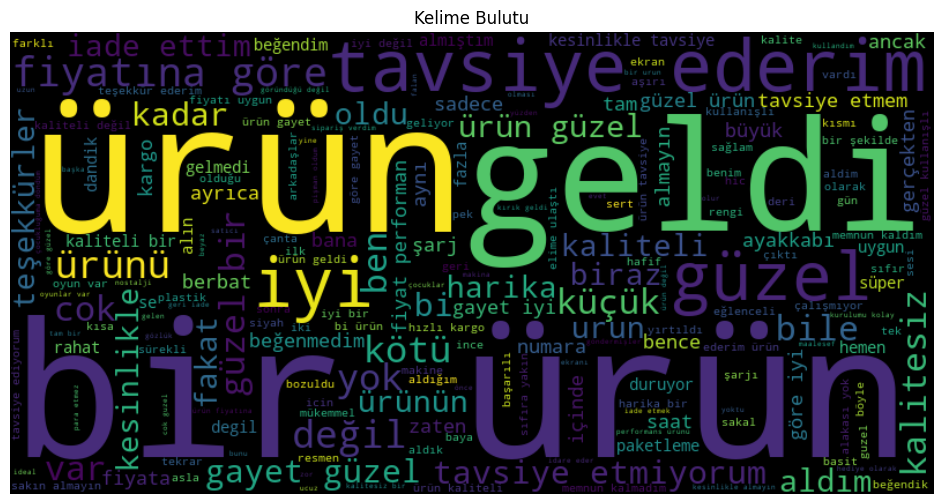

In [5]:
# H√ºcre 4: WordCloud
wc = WordCloud(width=800, height=400).generate(" ".join(df["temiz_yorum"]))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Kelime Bulutu")
plt.show()

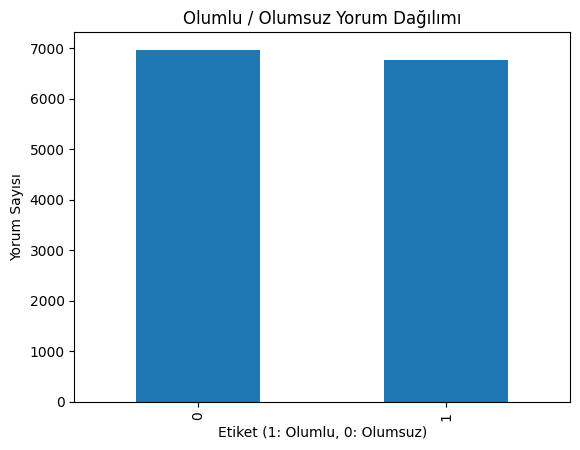

In [6]:
# H√ºcre 5: Olumlu-Olumsuz Daƒüƒ±lƒ±m
df["Durum"].value_counts().plot(kind="bar")
plt.title("Olumlu / Olumsuz Yorum Daƒüƒ±lƒ±mƒ±")
plt.xlabel("Etiket (1: Olumlu, 0: Olumsuz)")
plt.ylabel("Yorum Sayƒ±sƒ±")
plt.show()

In [7]:
# H√ºcre 6: Eƒüitim/Test Ayrƒ±mƒ± ve Model Eƒüitimi (Naive Bayes)
X_train, X_test, y_train, y_test = train_test_split(df["temiz_yorum"], df["Durum"], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)

y_pred_nb = model_nb.predict(X_test_vec)
print("Naive Bayes Doƒüruluk:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Doƒüruluk: 0.9530054644808743
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1378
           1       0.94      0.96      0.95      1367

    accuracy                           0.95      2745
   macro avg       0.95      0.95      0.95      2745
weighted avg       0.95      0.95      0.95      2745



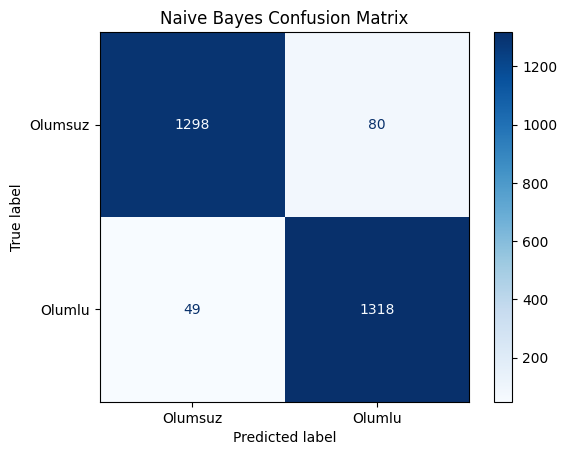

In [8]:
# H√ºcre 7: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Olumsuz", "Olumlu"])
disp.plot(cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.show()


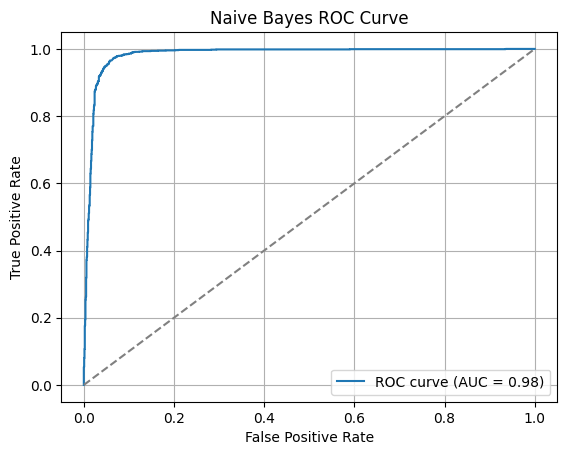

In [9]:
# H√ºcre 8: ROC Curve
y_probs = model_nb.predict_proba(X_test_vec)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# H√ºcre 9: Tahminleri Kaydet
df["tahmin"] = model_nb.predict(vectorizer.transform(df["temiz_yorum"]))
df["dogru_mu"] = df["Durum"] == df["tahmin"]
df.to_csv("yorum_tahmin_sonuclari.csv", index=False)
print("üìÅ Tahmin sonu√ßlarƒ± 'yorum_tahmin_sonuclari.csv' dosyasƒ±na kaydedildi.")


üìÅ Tahmin sonu√ßlarƒ± 'yorum_tahmin_sonuclari.csv' dosyasƒ±na kaydedildi.


In [11]:
# H√ºcre 10: Model Kar≈üƒ±la≈ütƒ±rmasƒ± (Logistic Regression & SVM)
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_vec, y_train)
y_pred_lr = model_lr.predict(X_test_vec)
print("\nLogistic Regression Doƒüruluk:", accuracy_score(y_test, y_pred_lr))

model_svm = LinearSVC()
model_svm.fit(X_train_vec, y_train)
y_pred_svm = model_svm.predict(X_test_vec)
print("\nSVM Doƒüruluk:", accuracy_score(y_test, y_pred_svm))



Logistic Regression Doƒüruluk: 0.9566484517304189

SVM Doƒüruluk: 0.9500910746812387


In [12]:
# H√ºcre 11: TF-IDF ile Kar≈üƒ±la≈ütƒ±rma
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model_tfidf_nb = MultinomialNB()
model_tfidf_nb.fit(X_train_tfidf, y_train)
y_pred_tfidf_nb = model_tfidf_nb.predict(X_test_tfidf)

print("\nTF-IDF Naive Bayes Doƒüruluk:", accuracy_score(y_test, y_pred_tfidf_nb))
print(classification_report(y_test, y_pred_tfidf_nb))



TF-IDF Naive Bayes Doƒüruluk: 0.9530054644808743
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1378
           1       0.95      0.96      0.95      1367

    accuracy                           0.95      2745
   macro avg       0.95      0.95      0.95      2745
weighted avg       0.95      0.95      0.95      2745



In [13]:
# H√ºcre 12: CountVectorizer vs TF-IDF Doƒüruluk Kar≈üƒ±la≈ütƒ±rmasƒ±
acc_count = accuracy_score(y_test, y_pred_nb)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf_nb)
print("\nüîç Vekt√∂rle≈ütirme Kar≈üƒ±la≈ütƒ±rmasƒ±")
print(f"CountVectorizer Doƒüruluk: {acc_count:.4f}")
print(f"TF-IDF           Doƒüruluk: {acc_tfidf:.4f}")


üîç Vekt√∂rle≈ütirme Kar≈üƒ±la≈ütƒ±rmasƒ±
CountVectorizer Doƒüruluk: 0.9530
TF-IDF           Doƒüruluk: 0.9530


In [14]:
# H√ºcre 13: Gradio ile Web Aray√ºz√º
def tahmin_gradio(yorum):
    temiz = temizle(yorum)
    vektor = vectorizer.transform([temiz])
    tahmin = model_nb.predict(vektor)[0]
    return "Olumlu üòä" if tahmin == 1 else "Olumsuz üòû"

gr.Interface(
    fn=tahmin_gradio,
    inputs=gr.Textbox(lines=3, placeholder="Yorumunuzu buraya girin..."),
    outputs="text",
    title="√úr√ºn Yorumlarƒ±ndan Duygu Tahmini",
    description="Bir yorum girin, model olumlu mu olumsuz mu olduƒüunu tahmin etsin."
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio\flagged\dataset1.csv
